In [1]:
import sys, os
sys.path.append('../src')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


In [66]:
dataPath = '../../data'
assetType = 'stocks'
asset = 'PETR4'
frequency = 'diario'
filePath = dataPath + '/' + assetType + '/' + asset + '/' + frequency + '/' + asset + '.CSV'

pathPETR4 = '../../data/stocks/PETR4/diario/PETR4.CSV'
pathIBOV = '../../data/indexes/IBOV/diario/IBOV.CSV'
pathUSDBRL = '../../data/forex/USDBRL/diario/USDBRL.CSV'
pathEURBRL = '../../data/forex/EURBRL/diario/EURBRL.CSV'

decomposeModel = 'additive'

saveVarDir = './Variables'
if not os.path.exists(saveVarDir):
    os.makedirs(saveVarDir)
    print('saveVarDir created')
else:
    print('saveVarDir already exists!')
saveFigDir = './Figures'
if not os.path.exists(saveFigDir):
    os.makedirs(saveFigDir)
    print('saveFigDir created')
else:
    print('saveFigDir already exists!')
saveFormat = 'png'

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

saveVarDir already exists!
saveFigDir already exists!


In [3]:
init_time = time.time()
PETR4 = acquireData(filePath = pathPETR4,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}, 
                                 {'column': 'Volume', 'lenght': 21}],
                    MACDParams = [{'fast_lenght': 12, 'slow_lenght': 26, 'signal_lenght': 9}],
                    BBParams = [{'lenght': 20}],
                    OBVParams = [{'lenght': None}],
                    deTrendParams = {'column': 'Close', 'window': 6, 'model': decomposeModel, 
                                     'weightModel': 'window_acorr', 'weightModelWindow': 18},
                    colPrefix = 'PETR4',
                    dropNan = True)

IBOV = acquireData(filePath = pathIBOV,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'IBOV',
                    dropNan = True)

USDBRL= acquireData(filePath = pathUSDBRL,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'USDBRL',
                    dropNan = True)


end_time = time.time()
print 'Time to acquire and process data: '+str(end_time-init_time)+' seconds'

Time to acquire and process data: 11.3766570091 seconds


In [9]:
df = pd.concat([PETR4, IBOV, USDBRL], axis = 1).dropna()

columnsToUse = ['PETR4_Close_resid', 
                'PETR4_Close_rollStd20', 
                'PETR4_Close_EMA17_logdiff', 'PETR4_Close_EMA72_logdiff', 'PETR4_Close_EMA200_logdiff', 'PETR4_Volume_EMA21_logdiff', 
                'PETR4_MACD_12_26_9', 'PETR4_MACDsignal_12_26_9', 'PETR4_Bollinger%b_20', 'PETR4_OBV', 
                'PETR4_Close_returns', 'PETR4_Close/Open_returns', 'PETR4_High/Close_returns', 'PETR4_Low/Close_returns', 
                'PETR4_Holiday',
                'IBOV_Close_rollStd20', 
                'IBOV_Close_EMA17_logdiff', 'IBOV_Close_EMA72_logdiff', 'IBOV_Close_EMA200_logdiff',
                'IBOV_Close_returns', 'IBOV_Close/Open_returns', 'IBOV_High/Close_returns', 'IBOV_Low/Close_returns',
                'USDBRL_Close_rollStd20', 
                'USDBRL_Close_EMA17_logdiff', 'USDBRL_Close_EMA72_logdiff', 'USDBRL_Close_EMA200_logdiff', 
                'USDBRL_Close_returns', 'USDBRL_Close/Open_returns', 'USDBRL_High/Close_returns', 'USDBRL_Low/Close_returns'
               ]

In [10]:
xTrain, yTrain, xTest, yTest = prepData(df = df, 
                                        columnsToUse = columnsToUse, columnToPredict = 'PETR4_Close_resid', 
                                        nDelays = 10, testSetSize = len(df['2017']))

numberOfTrainBatches = len(xTrain)
numberOfTrainInputs = len(xTrain[0])
print 'Number of train batches: {}'.format(numberOfTrainBatches)
print 'Number of inputs per batch: {}'.format(numberOfTrainInputs)
numberOTestBatches = len(xTest)
numberOTestInputs = len(xTest[0])
print 'Number of test batches: {}'.format(numberOTestBatches)
print 'Number of inputs per batch: {}'.format(numberOTestInputs)

Number of train batches: 4185
Number of inputs per batch: 40
Number of test batches: 175
Number of inputs per batch: 40


In [11]:
xScaler = MinMaxScaler(feature_range = (-1,1))
xScaler.fit(xTrain)

yScaler = MinMaxScaler(feature_range = (-1,1))
yScaler.fit(yTrain)

xTrain = xScaler.transform(xTrain)
xTest  = xScaler.transform(xTest)

yTrain = yScaler.transform(yTrain)

In [73]:
init_time = time.time()

model = Sequential([Dense(40, activation = 'tanh', input_dim = 40),
                    Dense(5, activation = 'tanh'),
                    Dense(1, activation = 'tanh')])

SGD = optimizers.SGD(lr=0.003, momentum=0.00, decay=0.0, nesterov=False)

model.compile(optimizer=SGD, loss='mean_squared_error')

end_time = time.time()
print 'Time to build model: '+str(end_time-init_time)+' seconds'
model.summary()

Time to build model: 0.0258588790894 seconds
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_47 (Dense)             (None, 5)                 205       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 6         
Total params: 1,851
Trainable params: 1,851
Non-trainable params: 0
_________________________________________________________________


In [74]:
init_time = time.time()

fitHistory = model.fit(xTrain, 
                       yTrain, 
                       epochs = 500,
                       verbose = 0,
                       shuffle = True,
                       validation_split = 0.15)

end_time = time.time()
print 'Time to fit model: '+str(end_time-init_time)+' seconds'

Time to fit model: 35.6096138954 seconds


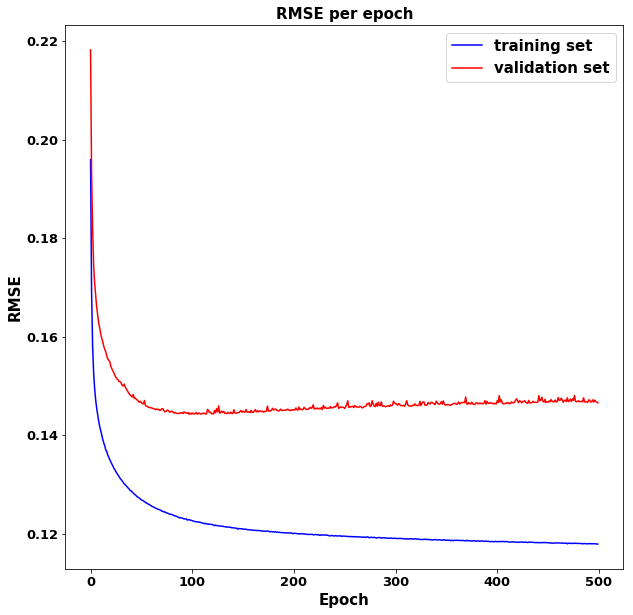

In [78]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(fitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(fitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
fig.savefig('{}/{}.{}'.format(saveFigDir, 'RMSE_per_epoch_ANNi40h5o1', 'pdf'), bbox_inches='tight')

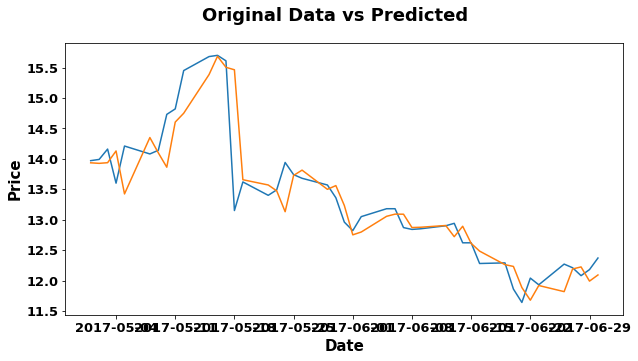

In [94]:
predictions = model.predict(xTest)
predictions = yScaler.inverse_transform(predictions)
predictions_clean = []
for p in predictions:
    predictions_clean.extend(p)
predictionsSeries = pd.Series(predictions_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_trend']+ df['PETR4_Close_resid'], 
#            df['PETR4_Close_trend'],
            df['PETR4_Close_trend'] + predictionsSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

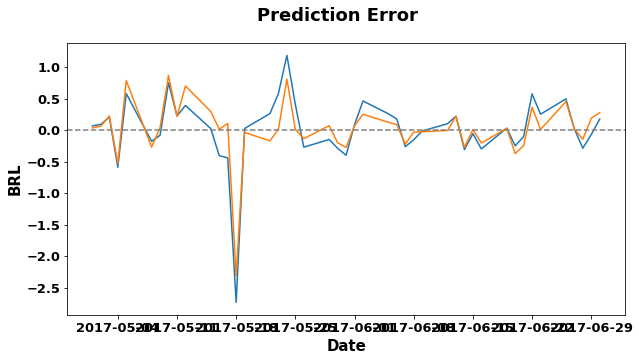

In [107]:
plotSeries([df['PETR4_Close'] - df['PETR4_Close_trend'], 
            df['PETR4_Close_resid'] - predictionsSeries],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'BRL')

In [ ]:
fig, ax = plot.subplots(figsize=(10,5), nrows = 1, ncols = 1)
fig.suptitle()

In [ ]:
plotCrosscorrelation(df_scalled['PETR4_Close_resid']['2017'], predictionsSeries['2017'])